In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from sklearn.model_selection import KFold
import warnings
import gc
import time
import sys
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings('ignore')
from sklearn import metrics

plt.style.use('seaborn')
sns.set(font_scale=2)
pd.set_option('display.max_columns', 500)

In [2]:
dtypes = {
        'MachineIdentifier':                                    'category',
        'ProductName':                                          'category',
        'EngineVersion':                                        'category',
        'AppVersion':                                           'category',
        'AvSigVersion':                                         'category',
        'IsBeta':                                               'int8',
        'RtpStateBitfield':                                     'float16',
        'IsSxsPassiveMode':                                     'int8',
        'DefaultBrowsersIdentifier':                            'float16',
        'AVProductStatesIdentifier':                            'float32',
        'AVProductsInstalled':                                  'float16',
        'AVProductsEnabled':                                    'float16',
        'HasTpm':                                               'int8',
        'CountryIdentifier':                                    'int16',
        'CityIdentifier':                                       'float32',
        'OrganizationIdentifier':                               'float16',
        'GeoNameIdentifier':                                    'float16',
        'LocaleEnglishNameIdentifier':                          'int8',
        'Platform':                                             'category',
        'Processor':                                            'category',
        'OsVer':                                                'category',
        'OsBuild':                                              'int16',
        'OsSuite':                                              'int16',
        'OsPlatformSubRelease':                                 'category',
        'OsBuildLab':                                           'category',
        'SkuEdition':                                           'category',
        'IsProtected':                                          'float16',
        'AutoSampleOptIn':                                      'int8',
        'PuaMode':                                              'category',
        'SMode':                                                'float16',
        'IeVerIdentifier':                                      'float16',
        'SmartScreen':                                          'category',
        'Firewall':                                             'float16',
        'UacLuaenable':                                         'float32',
#         'Census_MDC2FormFactor':                                'category',
#         'Census_DeviceFamily':                                  'category',
#         'Census_OEMNameIdentifier':                             'float16',
#         'Census_OEMModelIdentifier':                            'float32',
#         'Census_ProcessorCoreCount':                            'float16',
#         'Census_ProcessorManufacturerIdentifier':               'float16',
#         'Census_ProcessorModelIdentifier':                      'float16',
#         'Census_ProcessorClass':                                'category',
#         'Census_PrimaryDiskTotalCapacity':                      'float32',
#         'Census_PrimaryDiskTypeName':                           'category',
#         'Census_SystemVolumeTotalCapacity':                     'float32',
#         'Census_HasOpticalDiskDrive':                           'int8',
#         'Census_TotalPhysicalRAM':                              'float32',
#         'Census_ChassisTypeName':                               'category',
#         'Census_InternalPrimaryDiagonalDisplaySizeInInches':    'float16',
#         'Census_InternalPrimaryDisplayResolutionHorizontal':    'float16',
#         'Census_InternalPrimaryDisplayResolutionVertical':      'float16',
#         'Census_PowerPlatformRoleName':                         'category',
#         'Census_InternalBatteryType':                           'category',
#         'Census_InternalBatteryNumberOfCharges':                'float32',
#         'Census_OSVersion':                                     'category',
#         'Census_OSArchitecture':                                'category',
#         'Census_OSBranch':                                      'category',
#         'Census_OSBuildNumber':                                 'int16',
#         'Census_OSBuildRevision':                               'int32',
#         'Census_OSEdition':                                     'category',
#         'Census_OSSkuName':                                     'category',
#         'Census_OSInstallTypeName':                             'category',
#         'Census_OSInstallLanguageIdentifier':                   'float16',
#         'Census_OSUILocaleIdentifier':                          'int16',
#         'Census_OSWUAutoUpdateOptionsName':                     'category',
#         'Census_IsPortableOperatingSystem':                     'int8',
#         'Census_GenuineStateName':                              'category',
#         'Census_ActivationChannel':                             'category',
#         'Census_IsFlightingInternal':                           'float16',
#         'Census_IsFlightsDisabled':                             'float16',
#         'Census_FlightRing':                                    'category',
#         'Census_ThresholdOptIn':                                'float16',
#         'Census_FirmwareManufacturerIdentifier':                'float16',
#         'Census_FirmwareVersionIdentifier':                     'float32',
#         'Census_IsSecureBootEnabled':                           'int8',
#         'Census_IsWIMBootEnabled':                              'float16',
#         'Census_IsVirtualDevice':                               'float16',
#         'Census_IsTouchEnabled':                                'int8',
#         'Census_IsPenCapable':                                  'int8',
#         'Census_IsAlwaysOnAlwaysConnectedCapable':              'float16',
        'Wdft_IsGamer':                                         'float16',
        'Wdft_RegionIdentifier':                                'float16',
        'HasDetections':                                        'int8'
        }

In [3]:
%time train = pd.read_csv("data/malware/train.csv", dtype=dtypes)


Wall time: 1min 55s


In [4]:
%time test = pd.read_csv("data/malware/test.csv", dtype=dtypes)

Wall time: 1min 48s


In [5]:
# train['HasDetections'].value_counts().plot.bar()
# plt.title('HasDetections')

In [6]:
%%time
# check for missing data
# total = train.isnull().sum().sort_values(ascending=False)
# percent = (train.isnull().sum()/train.isnull().count()*100).sort_values(ascending=False)
# missing_train_data = pd.concat([total,percent],axis=1,keys=['Total','Percent'])

Wall time: 0 ns


In [7]:
# missing_train_data

In [8]:
null_cols_to_remove = ['DefaultBrowsersIdentifier', 'PuaMode',
                       'Census_IsFlightingInternal', 'Census_InternalBatteryType']

train.drop(null_cols_to_remove, axis=1, inplace=True)
test.drop(null_cols_to_remove, axis=1, inplace=True)

In [9]:
categorical_feats = [
        'ProductName',                                          
        'EngineVersion',                                        
        'AppVersion',                                           
        'AvSigVersion',                                         
        'Platform',                                             
        'Processor',                                            
        'OsVer',                                                
        'OsPlatformSubRelease',                                 
        'OsBuildLab',                                           
        'SkuEdition',                                           
        'SmartScreen'
#     ,                                          
#         'Census_MDC2FormFactor',                                
#         'Census_DeviceFamily',                                  
#         'Census_PrimaryDiskTypeName',                           
#         'Census_ChassisTypeName',                               
#         'Census_PowerPlatformRoleName',                         
#         'Census_OSVersion',                                     
#         'Census_OSArchitecture',                                
#         'Census_OSBranch',                                      
#         'Census_OSEdition',                                     
#         'Census_OSSkuName',                                     
#         'Census_OSInstallTypeName',                             
#         'Census_OSWUAutoUpdateOptionsName',                     
#         'Census_GenuineStateName',                              
#         'Census_ActivationChannel',                             
#         'Census_FlightRing'                                   
]

In [10]:
features = [
        'IsBeta',                                               
        'RtpStateBitfield',                                     
        'IsSxsPassiveMode',                                     
#         'DefaultBrowsersIdentifier',                            
        'AVProductStatesIdentifier',                            
        'AVProductsInstalled',                                  
        'AVProductsEnabled',                                    
        'HasTpm',                                               
        'CountryIdentifier',                                    
        'CityIdentifier',                                       
        'OrganizationIdentifier',                               
        'GeoNameIdentifier',                                    
        'LocaleEnglishNameIdentifier',                          
        'OsBuild',                                              
        'OsSuite',                                              
        'IsProtected',                                          
        'AutoSampleOptIn',                                      
        'SMode',                                                
        'IeVerIdentifier',                                      
        'Firewall',                                             
        'UacLuaenable',                                         
#         'Census_OEMNameIdentifier',                             
#         'Census_OEMModelIdentifier',                            
#         'Census_ProcessorCoreCount',                            
#         'Census_ProcessorManufacturerIdentifier',               
#         'Census_ProcessorModelIdentifier',                      
#         'Census_PrimaryDiskTotalCapacity',                      
#         'Census_SystemVolumeTotalCapacity',                     
#         'Census_HasOpticalDiskDrive',                           
#         'Census_TotalPhysicalRAM',                              
#         'Census_InternalPrimaryDiagonalDisplaySizeInInches',    
#         'Census_InternalPrimaryDisplayResolutionHorizontal',    
#         'Census_InternalPrimaryDisplayResolutionVertical',      
#         'Census_InternalBatteryNumberOfCharges',                
#         'Census_OSBuildNumber',                                 
#         'Census_OSBuildRevision',                               
#         'Census_OSInstallLanguageIdentifier',                   
#         'Census_OSUILocaleIdentifier',                          
#         'Census_IsPortableOperatingSystem',                     
#         'Census_IsFlightsDisabled',                             
#         'Census_ThresholdOptIn',                                
#         'Census_FirmwareManufacturerIdentifier',                
#         'Census_FirmwareVersionIdentifier',                     
#         'Census_IsSecureBootEnabled',                           
#         'Census_IsWIMBootEnabled',                              
#         'Census_IsVirtualDevice',                               
#         'Census_IsTouchEnabled',                                
#         'Census_IsPenCapable',                                  
#         'Census_IsAlwaysOnAlwaysConnectedCapable',              
        'Wdft_IsGamer',                                         
        'Wdft_RegionIdentifier'                               
]

In [11]:
# MachineIdentifier,HasDetections
dep = 'HasDetections'
df_train1 = train[categorical_feats+features+[dep]].copy()

In [12]:
test[dep] = 0.0
df_test1 = test[categorical_feats+features+[dep, 'MachineIdentifier']].copy()

In [13]:
from fastai.learner import *
from fastai.column_data import *
from fastai.structured import *

In [14]:
for v in categorical_feats: df_train1[v] = df_train1[v].astype('category').cat.as_ordered()
apply_cats(df_test1, df_train1)

In [15]:
del train

In [16]:
del test

In [17]:
gc.collect()

98

In [35]:
samp_size = len(df_train1)
df, y, nas, mapper = proc_df(df_train1, dep, do_scale=False)

ValueError: not enough values to unpack (expected 4, got 3)

In [20]:
df_test2, _, nas, mapper = proc_df(df_test1, dep, do_scale=False,skip_flds=['MachineIdentifier'],mapper=mapper, na_dict=nas)

In [21]:
train_ratio = 0.75
# train_ratio = 0.9
train_size = int(samp_size * train_ratio); train_size
val_idx = list(range(train_size, len(df)))

In [22]:
def exp_rmse(y_pred, targ):
#     targ = inv_y(targ)
    pct_var = (targ - y_pred)
    return math.sqrt((pct_var**2).mean())

y_range = (0, 1)

In [24]:
PATH=Path('data/malware')

In [25]:
md = ColumnarModelData.from_data_frame(PATH, val_idx, df, y.astype(np.float32), cat_flds=categorical_feats, bs=128,
                                       test_df=df_test2)

In [26]:
cat_sz = [(c, len(df_train1[c].cat.categories)+1) for c in categorical_feats]
cat_sz

[('ProductName', 7),
 ('EngineVersion', 71),
 ('AppVersion', 111),
 ('AvSigVersion', 8532),
 ('Platform', 5),
 ('Processor', 4),
 ('OsVer', 59),
 ('OsPlatformSubRelease', 10),
 ('OsBuildLab', 664),
 ('SkuEdition', 9),
 ('SmartScreen', 22)]

In [27]:
emb_szs = [(c, min(50, (c+1)//2)) for _,c in cat_sz]
emb_szs

[(7, 4),
 (71, 36),
 (111, 50),
 (8532, 50),
 (5, 3),
 (4, 2),
 (59, 30),
 (10, 5),
 (664, 50),
 (9, 5),
 (22, 11)]

In [28]:
m = md.get_learner(emb_szs,len(df.columns)-len(categorical_feats),0.04,1,[1000,500],[0.001,0.01])

In [30]:
m.model

MixedInputModel(
  (embs): ModuleList(
    (0): Embedding(7, 4)
    (1): Embedding(71, 36)
    (2): Embedding(111, 50)
    (3): Embedding(8532, 50)
    (4): Embedding(5, 3)
    (5): Embedding(4, 2)
    (6): Embedding(59, 30)
    (7): Embedding(10, 5)
    (8): Embedding(664, 50)
    (9): Embedding(9, 5)
    (10): Embedding(22, 11)
  )
  (lins): ModuleList(
    (0): Linear(in_features=282, out_features=1000, bias=True)
    (1): Linear(in_features=1000, out_features=500, bias=True)
  )
  (bns): ModuleList(
    (0): BatchNorm1d(1000, eps=1e-05, momentum=0.1, affine=True)
    (1): BatchNorm1d(500, eps=1e-05, momentum=0.1, affine=True)
  )
  (outp): Linear(in_features=500, out_features=1, bias=True)
  (emb_drop): Dropout(p=0.04)
  (drops): ModuleList(
    (0): Dropout(p=0.001)
    (1): Dropout(p=0.01)
  )
  (bn): BatchNorm1d(36, eps=1e-05, momentum=0.1, affine=True)
)

  0%|                                                                              | 0/52275 [00:00<?, ?it/s, loss=nan]


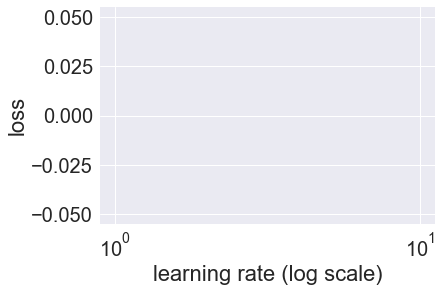

In [32]:
lr=1e-3
m.lr_find()
m.sched.plot(100)

In [33]:
lr=1e-4
m = md.get_learner(emb_szs, len(df.columns)-len(categorical_feats),
                   0.04, 1, [1000,500], [0.001,0.01])


In [34]:
m.fit(lr, 5,metrics=[exp_rmse],cycle_len=1)

  2%|█▌                                                                 | 1174/52275 [00:15<11:01, 77.21it/s, loss=nan]

KeyboardInterrupt: 

  2%|█▌                                                                 | 1174/52275 [00:30<21:46, 39.11it/s, loss=nan]